## Importing Libraries 

In [1]:
import numpy as np #multi dimensional library
import pandas as pd #data manipulation and analysis
import seaborn as sns #visualization 
import matplotlib.pyplot as plt #visualization 
import nltk #analyze unstructured data 
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer #term frequency inverse document information retrieval string representation
from bs4 import BeautifulSoup 
import re,string,unicodedata #regix 
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.linear_model import LogisticRegression,SGDClassifier # machine learning models
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score 


## Load Dataset

In [2]:
dataset=pd.read_csv('IMDB Dataset.csv')
print(dataset.shape)
dataset.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
tagging = {'positive':1, 'negative':0}

dataset['sentiment'] = dataset['sentiment'].apply(lambda i : tagging[i])
# Output first five rows
dataset.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## Exploratory Data Analysis

In [4]:
#checking null values
dataset.isna().sum()

review       0
sentiment    0
dtype: int64

<AxesSubplot:xlabel='sentiment'>

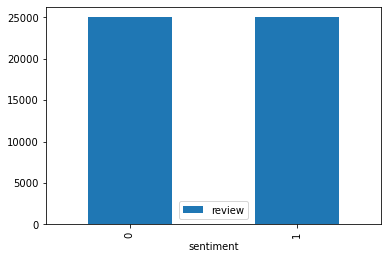

In [5]:
# The seperation of sentiments
dataset.groupby('sentiment').count().plot(kind='bar')

<AxesSubplot:>

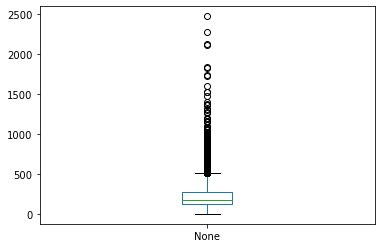

In [6]:
review = pd.Series([len(review.split()) for review in dataset['review']])

# The s oeperationf review text lengths
review.plot(kind='box')

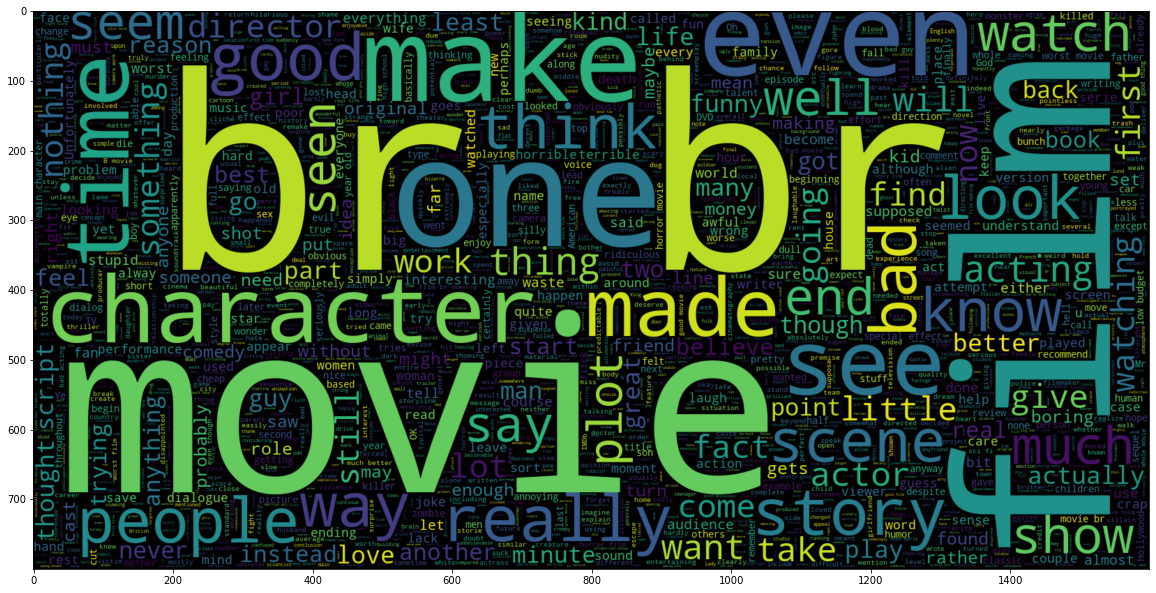

In [7]:
#!pip install wordcloud
from wordcloud import WordCloud
# Negative Review wordcloud Text
plt.figure(figsize = (20,20)) 
word_cloud = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(dataset[dataset.sentiment == 0].review))
plt.imshow(word_cloud , interpolation = 'bilinear')

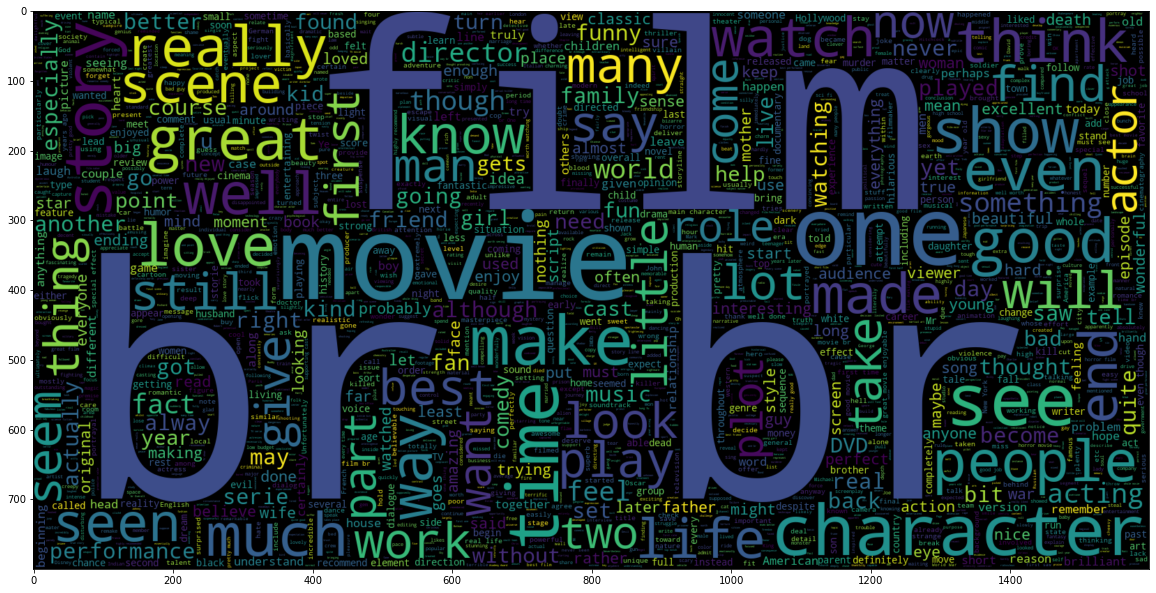

In [8]:
# Positive Review Text
plt.figure(figsize = (20,20)) 
word_cloud = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(dataset[dataset.sentiment == 1].review))
plt.imshow(word_cloud , interpolation = 'bilinear')

In [9]:
#statistics of dataset
dataset.describe()

,sentiment
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [10]:
#count values
dataset['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

## Splitting train test

In [11]:
#split the dataset  
#train dataset
train_rev=dataset.review[:40000]
train_sen=dataset.sentiment[:40000]
#test dataset
test_rev=dataset.review[40000:]
test_sen=dataset.sentiment[40000:]
print(train_rev.shape,train_sen.shape)
print(test_rev.shape,test_sen.shape)

(40000,) (40000,)
(10000,) (10000,)


## Pre-Processing

In [12]:
#lower casing
dataset.review=dataset.review.str.lower()  

#replacing 
dataset.review=dataset.review.str.replace('<[^<]+?>','') 
dataset["review"] = dataset['review'].str.replace('[^\w\s]','')


In [13]:
#removing html
def html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#removing brackets
def brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Function with removing all sort of noise
def clear_text(text):
    text = html(text)
    text = brackets(text)
    return text
dataset['review']=dataset['review'].apply(clear_text)

In [15]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')
#removing the stopwords
def stopwords_del(text, is_lower_case=False):
    tok = tokenizer.tokenize(text)
    tok = [token.strip() for token in tok]
    if is_lower_case:
        alter_tokens = [token for token in tok if token not in stopword_list]
    else:
        alter_tokens = [token for token in tok if token.lower() not in stopword_list]
    alter_text = ' '.join(alter_tokens)    
    return alter_text

dataset['review']=dataset['review'].apply(stopwords_del)

In [16]:
train_rev=dataset.review[:40000]
train_rev[0]

'one reviewers mentioned watching 1 oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle 

In [17]:
test_rev=dataset.review[40000:]
test_rev[45005]


'read reviews watching piece cinematic garbage took least 2 pages find somebody else didnt think appallingly unfunny montage wasnt acme humour 70s indeed era isnt least funny set sketch comedy ive ever seen itll till comes along half skits already done infinitely better acts monty python woody allen say nice piece animation lasts 90 seconds highlight film would still get close summing mindless drivelridden waste 75 minutes seminal comedy world seminal really mean semen scatological humour world scat actually feces precursor jokes mean handbook comedy tits bums odd beaver niceif pubescent boy least one hand free havent found playboy exists give break early 70s way sketch comedy going back least ten years prior way could even forgive film even made gunpoint retro hardly sketches clowns subtly perverting children may cutting edge circles could actually funny comes really quite sad kept going throughout entire 75 minutes sheer belief may saved genuinely funny skit end gave film 1 lower sco

In [19]:
#Tfidf vectorizer
tf_vec=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tf_vec_train_rev=tf_vec.fit_transform(train_rev)
#transformed test reviews
tf_vec_test_rev=tf_vec.transform(test_rev)
print('TRAIN:',tf_vec_train_rev.shape)
print('TEST:',tf_vec_test_rev.shape)

TRAIN: (40000, 6677306)
TEST: (10000, 6677306)


## Normalization

In [23]:

label_binary=LabelBinarizer()
#transformed sentiment data
transform_sent_data=label_binary.fit_transform(dataset['sentiment'])
print(transform_sent_data.shape)

(50000, 1)


In [24]:
train_sent=transform_sent_data[:40000]
test_sent=transform_sent_data[40000:]
print(train_sent)
print(test_sent)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


## Training Logistic Regression

In [26]:
#training the model
logistic_reg=LogisticRegression(penalty='l2',max_iter=1000,C=1,random_state=50)

#Fitting the model 
logistic_reg_tf_idf=logistic_reg.fit(tf_vec_train_rev,train_sent)
print(logistic_reg_tf_idf)

C:\Users\okagg\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression(C=1, max_iter=1000, random_state=50)


## Predicting

In [27]:
#Predicting the model 
logistic_reg_tf_idf_predict=logistic_reg.predict(tf_vec_test_rev)
print(logistic_reg_tf_idf_predict)

[0 0 0 ... 0 0 0]


In [28]:
#Accuracy score for tfidf features
logistic_reg_tf_idf_score=accuracy_score(test_sent,logistic_reg_tf_idf_predict)
print("logistic_tfidf_score :",logistic_reg_tf_idf_score)

logistic_tfidf_score : 0.7443


In [29]:
#Classification report for tfidf features
logistic_tf_idf_report=classification_report(test_sent,logistic_reg_tf_idf_predict,target_names=['Positive','Negative'])
print(logistic_tf_idf_report)

              precision    recall  f1-score   support

    Positive       0.73      0.77      0.75      4993
    Negative       0.76      0.72      0.74      5007

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



### Confusion matrix

<AxesSubplot:>

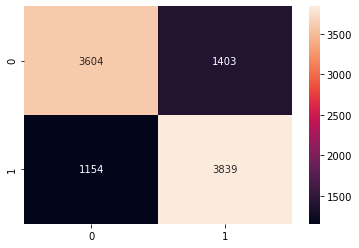

In [31]:
#confusion matrix for tfidf features
confusion_matrix_tf_idf=confusion_matrix(test_sent,logistic_reg_tf_idf_predict,labels=[1,0])
sns.heatmap(confusion_matrix_tf_idf,annot=True,fmt='d')

## Training stochastic gradient descent

In [32]:
sgd=SGDClassifier(loss='hinge',max_iter=1000,random_state=42)
#fitting the svm for tfidf features
sgd_tf_idf=sgd.fit(tf_vec_train_rev,train_sent)
print(sgd_tf_idf)

C:\Users\okagg\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SGDClassifier(random_state=42)


## Prediction

In [33]:
#Predicting the model for tfidf features
sgd_tfidf_predict=sgd.predict(tf_vec_test_rev)
print(sgd_tfidf_predict)

[1 1 1 ... 1 1 1]


In [35]:
#Accuracy score for tfidf features
sgd_tfidf_score=accuracy_score(test_sent,sgd_tfidf_predict)
print("stochastic gradient descent score :",sgd_tfidf_score)

stochastic gradient descent score : 0.5111


In [36]:
#Classification report for tfidf features
sgd_tfidf_report=classification_report(test_sent,sgd_tfidf_predict,target_names=['Positive','Negative'])
print(sgd_tfidf_report)

              precision    recall  f1-score   support

    Positive       1.00      0.02      0.04      4993
    Negative       0.51      1.00      0.67      5007

    accuracy                           0.51     10000
   macro avg       0.75      0.51      0.36     10000
weighted avg       0.75      0.51      0.36     10000



### Confusion matrix

<AxesSubplot:>

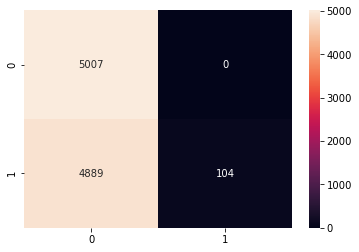

In [37]:
#confusion matrix for tfidf features
confusionatrix_tfidf=confusion_matrix(test_sent,sgd_tfidf_predict,labels=[1,0])
sns.heatmap(confusionatrix_tfidf,annot=True,fmt='d')

In [38]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(n_estimators=50,criterion='entropy')
model.fit(tf_vec_train_rev,train_sent)

<ipython-input-38-e3e4fd729653>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(tf_vec_train_rev,train_sent)


RandomForestClassifier(criterion='entropy', n_estimators=50)

In [39]:
rf_tfidf_predict=model.predict(tf_vec_test_rev)
print(rf_tfidf_predict)

[0 0 0 ... 0 0 0]


In [40]:
#Accuracy score for tfidf features
rf_tfidf_score=accuracy_score(test_sent,sgd_tfidf_predict)
print("stochastic gradient descent score :",rf_tfidf_score)

stochastic gradient descent score : 0.5111


In [41]:
rf_tfidf_report=classification_report(test_sent,rf_tfidf_predict,target_names=['Positive','Negative'])
print(rf_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.50      1.00      0.67      4993
    Negative       1.00      0.01      0.02      5007

    accuracy                           0.50     10000
   macro avg       0.75      0.51      0.34     10000
weighted avg       0.75      0.50      0.34     10000



<AxesSubplot:>

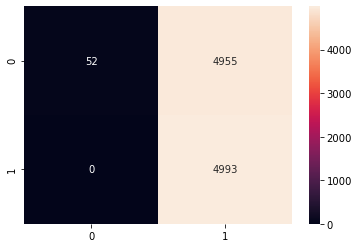

In [42]:
confusionatrix_tfidf=confusion_matrix(test_sent,rf_tfidf_predict,labels=[1,0])
sns.heatmap(confusionatrix_tfidf,annot=True,fmt='d')